In [2]:
# !pip install langgraph langchain langchain-community langchain-groq

In [64]:
from langgraph.graph import StateGraph, MessagesState, START, END
from langgraph.graph.message import add_messages
from typing import Annotated, TypedDict
from langchain_groq import ChatGroq
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_community.tools import TavilySearchResults
from langchain_core.prompts import ChatPromptTemplate, MessagesPlaceholder
from IPython.display import Image, Markdown


In [4]:
from getpass import getpass
GROQ_API_KEY = getpass("Enter your Groq API key: ")

In [5]:
TAVILY_API_KEY = getpass('Enter Tavily Search API Key: ')

In [6]:
import os
os.environ['GROQ_API_KEY'] = GROQ_API_KEY
os.environ['TAVILY_API_KEY'] = TAVILY_API_KEY

In [ ]:
#defining systemprompt

# prompt_temp = """
# You are a business research assistant for a Max Fashion store. 
# Given a location you need to gather the competitor brand in that location, their foot fall trend, 
# peak hours and offers they provide. Based on these information you need to provide a short report to the store manager. 
# Get the most recent inforamtion available on the internet also the date. Always use the tools provided. 

# You must provide report only based on the information you have gathered. If user ask anything outside the scope, just reply "Not in Scope".
# If you don't have information about a particular aspect, you can say "Not Found". if the given location doesnt exist then reply "Location doesnt exist".
# Dont hallucinate and make up information. 
# """

prompt_temp = """
Act as a Max Fashion research assistant. For a given location, use tools to find: competitor brands, footfall trends, peak hours, and current offers. 
Provide a short report for the store manager including the data source date. If info is missing, say 'Not Found'. 
If the location is invalid, say 'Location doesn't exist'. For topics outside this scope, reply 'Not in Scope'. Do not hallucinate. Be concise."""

prompt_template = ChatPromptTemplate.from_messages(
    [
        ("system",prompt_temp),
        MessagesPlaceholder(variable_name="messages"),
    ]
)

In [127]:
llm = ChatGroq(model_name="llama-3.3-70b-versatile", temperature=0)
# llama-3.1-8b-instant
# openai/gpt-oss-120b


tavily_search = TavilySearchResults(max_results=3,max_tokens=1000)
tools = [tavily_search]
# llm_mod = (prompt_template | llm)

llm_mod = (prompt_template | llm.bind_tools(tools))

tool_node = ToolNode(tools)

In [128]:
def call_model(state: MessagesState):
    response = llm_mod.invoke(state['messages'])

    return {'messages': [response]}

In [129]:
graph = StateGraph(MessagesState)
graph.add_node("agent",call_model)
graph.add_node("tools",tool_node)
graph.add_edge(START, "agent")
graph.add_conditional_edges("agent",tools_condition, ["tools",END])
graph.add_edge("tools","agent")


In [130]:
r_graph = graph.compile()

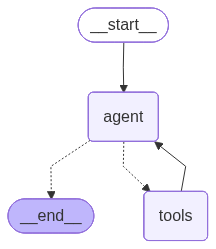

In [131]:
Image(r_graph.get_graph().draw_mermaid_png())

In [132]:
output = r_graph.invoke({'messages': [
    ('user', 'Location : Marathahalli')
]})

Markdown(output['messages'][-1].content)

Competitor brands: Brand Factory, Max, Nalli, Manyavar, Westside, Trends, Birkenstock
Footfall trends: Peak hours are morning (8-10) and evening (6-8), with very high traffic levels. Afternoon traffic is moderate.
Peak hours: Morning (8-10) and evening (6-8)
Current offers: Branded Fashion Expo, Big Branded Sale, Direct Booking Offer, Early Bird Discount, Member-Only Rate, 10% Off Your Culinary Adventure
Data source date: 2026

In [133]:
output

{'messages': [HumanMessage(content='Location : Marathahalli', additional_kwargs={}, response_metadata={}, id='a19e4ad9-c8a0-4b00-9e86-2102d0b6386e'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'fejcfa8zt', 'function': {'arguments': '{"query":"Marathahalli competitor brands"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'ne5v7kdsc', 'function': {'arguments': '{"query":"Marathahalli footfall trends"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': '1sn5mkceg', 'function': {'arguments': '{"query":"Marathahalli peak hours"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'znady8nyb', 'function': {'arguments': '{"query":"Marathahalli current offers"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 90, 'prompt_tokens': 375, 'total_tokens': 465, 'completion_time': 0.160304036, 'completion_tokens_details': None, 'prompt_time': 0.0239147

In [134]:

output = r_graph.invoke({'messages': [
    ('user', 'Location : Jaya nagar, bangalore')
]})

Markdown(output['messages'][-1].content)


Competitor brands: Shoppers Stop, Pantaloons, and other local stores in Jayanagar, Bangalore.
Footfall trends: The footfall in the store has decreased over the years due to the rise of online shopping, with a 50% decline in footfall between 2019 and 2024.
Peak hours: Not Found
Current offers: Not Found
Data source date: 2025

In [135]:
output

{'messages': [HumanMessage(content='Location : Jaya nagar, bangalore', additional_kwargs={}, response_metadata={}, id='23ef19fb-967e-467a-8054-86f0ca7f3041'),
  AIMessage(content='', additional_kwargs={'tool_calls': [{'id': '1r2g6hc3g', 'function': {'arguments': '{"query":"competitor brands of Max Fashion in Jaya Nagar, Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': '8hhv3h2zc', 'function': {'arguments': '{"query":"footfall trends of Max Fashion in Jaya Nagar, Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': 'jqkh8sn56', 'function': {'arguments': '{"query":"peak hours of Max Fashion in Jaya Nagar, Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}, {'id': '4r0p8kfqp', 'function': {'arguments': '{"query":"current offers of Max Fashion in Jaya Nagar, Bangalore"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 111, 'prompt_tokens':